In [1]:
import os
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, KBinsDiscretizer
from aif360.sklearn.datasets import fetch_adult
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler

In [2]:
X = fetch_adult()
X

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


WeightedDataset(X=                   age     workclass     education  education-num  \
race      sex                                                       
Non-white Male    25.0       Private          11th            7.0   
White     Male    38.0       Private       HS-grad            9.0   
          Male    28.0     Local-gov    Assoc-acdm           12.0   
Non-white Male    44.0       Private  Some-college           10.0   
White     Male    34.0       Private          10th            6.0   
...                ...           ...           ...            ...   
          Female  27.0       Private    Assoc-acdm           12.0   
          Male    40.0       Private       HS-grad            9.0   
          Female  58.0       Private       HS-grad            9.0   
          Male    22.0       Private       HS-grad            9.0   
          Female  52.0  Self-emp-inc       HS-grad            9.0   

                      marital-status         occupation   relationship   race  \
rac

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, KBinsDiscretizer

def calculate_num_bins(num_unique_values, value_range):
    num_bins = min(6, int(np.log2(num_unique_values)) + 1)
    num_bins = min(num_bins, value_range)
    return num_bins


def preprocess_dataset(df, continuous_features=[], one_hot_encode=True, datasetName="Adult"):
    label_encoder = LabelEncoder()
    onehot_encoder = OneHotEncoder()

    numeric_columns = []
    categorical_columns = []

    for col in df.columns:
        if df[col].dtype == 'object' or df[col].dtype == 'category' and col not in continuous_features:
            categorical_columns.append(col)
            if len(df[col].unique()) == 2:
                df[col] = label_encoder.fit_transform(df[col])
            elif one_hot_encode or (one_hot_encode and datasetName == "Adult" and col == 'race'):
                encoded_values = onehot_encoder.fit_transform(df[[col]])
                categories = onehot_encoder.categories_[0]
                new_cols = [col + '_' + str(category) for category in categories]
                encoded_df = pd.DataFrame(encoded_values.toarray(), columns=new_cols)
                df = pd.concat([df, encoded_df], axis=1)
                df.drop(col, axis=1, inplace=True)
        elif df[col].dtype == 'object' or df[col].dtype == 'category' and df[col].str.isnumeric().all() and col not in continuous_features:
            df[col] = df[col].astype(int)
            categorical_columns.append(col)
        elif col in continuous_features:
            numeric_columns.append(col)
            num_unique_values = len(df[col].unique())
            value_range = df[col].max() - df[col].min()
            num_bins = calculate_num_bins(num_unique_values, value_range)

            bin_discretizer = KBinsDiscretizer(n_bins=num_bins, encode='ordinal', strategy='uniform', subsample=None)
            bins = bin_discretizer.fit_transform(df[[col]])
            df[col] = bins.astype(int)
        else:
            if len(df[col].unique()) > 2:
                numeric_columns.append(col)
    return df, numeric_columns, categorical_columns

In [4]:
def load_adult():
    data_df = pd.read_csv(f"adult.csv")
    # Drop the target column
    TARGET_COLUMNS = data_df.columns[-1]
    data = data_df.drop(columns=[TARGET_COLUMNS])

    data, numeric_columns, categorical_columns = preprocess_dataset(data, continuous_features=[])
    data_df_copy = data.copy()
    # Scale the dataset
    min_max_scaler = preprocessing.MinMaxScaler()
    data_scaled = min_max_scaler.fit_transform(data)
    data = pd.DataFrame(data_scaled, columns=data.columns)

    FEATURE_COLUMNS = data.columns

    # Add the target column back
    data[TARGET_COLUMNS] = data_df[TARGET_COLUMNS]

    return data, FEATURE_COLUMNS, TARGET_COLUMNS, numeric_columns, categorical_columns

In [5]:
data = load_adult()
data

(            age  workclass  education  education-num  marital-status  \
 0      0.301370      0.875   0.600000       0.800000        0.666667   
 1      0.452055      0.750   0.600000       0.800000        0.333333   
 2      0.287671      0.500   0.733333       0.533333        0.000000   
 3      0.493151      0.500   0.066667       0.400000        0.333333   
 4      0.150685      0.500   0.600000       0.800000        0.333333   
 ...         ...        ...        ...            ...             ...   
 48837  0.301370      0.500   0.600000       0.800000        0.000000   
 48838  0.643836      0.000   0.733333       0.533333        1.000000   
 48839  0.287671      0.500   0.600000       0.800000        0.333333   
 48840  0.369863      0.500   0.600000       0.800000        0.000000   
 48841  0.246575      0.625   0.600000       0.800000        0.333333   
 
        occupation  relationship  race  sex  capital-gain  capital-loss  \
 0        0.071429           0.2  1.00  1.0    

In [6]:
data, FEATURE_COLUMNS, TARGET_COLUMNS, numeric_columns, categorical_columns = load_adult()

print(data.columns)

Index(['age', 'workclass', 'education', 'education-num', 'marital-status',
       'occupation', 'relationship', 'race', 'sex', 'capital-gain',
       'capital-loss', 'hours-per-week', 'target'],
      dtype='object')


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def calculate_metrics_and_split_data(data, features, target, classifier_type='logistic_regression',
                                     metrics=['accuracy'], attribute=None):
    """
    Train a classifier, predict on test data, calculate specified metrics from the confusion matrix,
    and optionally split the test data based on an attribute.

    :param data: DataFrame containing the dataset
    :param features: List of feature column names
    :param target: Name of the target column
    :param classifier_type: Type of classifier ('logistic_regression', 'svm', 'random_forest', 'naive_bayes')
    :param metrics: List of metrics to calculate ('accuracy', 'precision', 'recall', 'f1', 'tp', 'tn', 'fp', 'fn')
    :param attribute: Optional attribute to split the test data on, which should be binary (0 or 1)
    :return: Dictionary of requested metrics and optionally two DataFrames, one for each value of the attribute,
             and the trained model instance, and the preprocessor
    """
    # Encode categorical features and scale numerical features
    categorical_features = data[features].select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_features = data[features].select_dtypes(include=['int64', 'float64']).columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(), categorical_features)])

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.2, random_state=42)

    # Debugging: Print the shape of the train and test sets
    print(f"Training data shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Testing data shape: X_test: {X_test.shape}, y_test: {y_test.shape}")

    # Initialize classifier
    classifiers = {
        'logistic_regression': LogisticRegression(max_iter=500, solver='saga'),
        'svm': SVC(probability=True),
        'random_forest': RandomForestClassifier(),
        'naive_bayes': GaussianNB()
    }
    classifier = classifiers[classifier_type]

    # Fit the classifier and predict
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', classifier)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    tp = cm[1, 1]  # True Positives
    tn = cm[0, 0]  # True Negatives
    fp = cm[0, 1]  # False Positives
    fn = cm[1, 0]  # False Negatives

    # Debugging: Print the confusion matrix
    print("Confusion Matrix:")
    print(cm)

    # Calculate metrics
    metrics_dict = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='binary'),
        'recall': recall_score(y_test, y_pred, average='binary'),
        'f1': f1_score(y_test, y_pred, average='binary'),
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn
    }

    # Print accuracy
    print(f"Accuracy: {metrics_dict['accuracy']}")

    # Validate metrics
    results = {}
    for metric in metrics:
        if metric not in metrics_dict:
            raise ValueError(
                f"Unsupported metric '{metric}'. Choose from 'accuracy', 'precision', 'recall', 'f1', 'tp', 'tn', 'fp', 'fn'.")
        results[metric] = metrics_dict[metric]

    # Add target and predictions to test features
    X_test_df = X_test.copy()
    X_test_df[target] = y_test.values
    X_test_df['pred'] = y_pred

    # Debugging: Print the test data with all columns
    print("Test data with all columns:")
    print(X_test_df.head())

    return results, X_test_df, pipeline

In [8]:
def generate_tn_fn_dataframes(test_df, target, attribute):
    group_0 = test_df[test_df[attribute] == 0]
    group_1 = test_df[test_df[attribute] == 1]
    print(f"Group 0 size: {group_0.shape[0]}")
    print(f"Group 1 size: {group_1.shape[0]}")
    y_true_0 = group_0[target]
    y_pred_0 = group_0['pred']
    tn_0, fp_0, fn_0, tp_0 = confusion_matrix(y_true_0, y_pred_0).ravel()
    print(f"Confusion Matrix for Group 0: TN={tn_0}, FP={fp_0}, FN={fn_0}, TP={tp_0}")
    y_true_1 = group_1[target]
    y_pred_1 = group_1['pred']
    tn_1, fp_1, fn_1, tp_1 = confusion_matrix(y_true_1, y_pred_1).ravel()
    print(f"Confusion Matrix for Group 1: TN={tn_1}, FP={fp_1}, FN={fn_1}, TP={tp_1}")
 # Create DataFrames for TN and FN
    tn_df_0 = group_0[(group_0[target] == 0) & (group_0['pred'] == 0)].drop(columns=[target, 'pred'])
    fn_df_0 = group_0[(group_0[target] == 1) & (group_0['pred'] == 0)].drop(columns=[target, 'pred'])

    tn_df_1 = group_1[(group_1[target] == 0) & (group_1['pred'] == 0)].drop(columns=[target, 'pred'])
    fn_df_1 = group_1[(group_1[target] == 1) & (group_1['pred'] == 0)].drop(columns=[target, 'pred'])

    print(f"TN Group 0 size: {tn_df_0.shape[0]}")
    print(f"FN Group 0 size: {fn_df_0.shape[0]}")
    print(f"TN Group 1 size: {tn_df_1.shape[0]}")
    print(f"FN Group 1 size: {fn_df_1.shape[0]}")
    return tn_df_0, fn_df_0, tn_df_1, fn_df_1

In [12]:
data, features, target, numeric_columns, categorical_columns = load_adult()

target = 'target'
attribute = 'sex'
classifier_type = 'logistic_regression'

# Calculate metrics and get the test DataFrame with predictions
results, test_df, trained_model = calculate_metrics_and_split_data(data, features, target, classifier_type, attribute=attribute)

# Generate DataFrames for true positives and false positives
tn_df_0, fn_df_0, tn_df_1, fn_df_1 = generate_tn_fn_dataframes(test_df, target, attribute)

print("Results:")
for metric, value in results.items():
    print(f"{metric}: {value}")

print("True Positives Group 0 (first 5 rows):")
print(tn_df_0.head())

print("False Positives Group 0 (first 5 rows):")
print(fn_df_0.head())

print("True Positives Group 1 (first 5 rows):")
print(tn_df_1.head())

print("False Positives Group 1 (first 5 rows):")
print(fn_df_1.head())

Training data shape: X_train: (39073, 12), y_train: (39073,)
Testing data shape: X_test: (9769, 12), y_test: (9769,)
Confusion Matrix:
[[1049 1306]
 [ 402 7012]]
Accuracy: 0.8251612242808886
Test data with all columns:
            age  workclass  education  education-num  marital-status  \
7762   0.013699       0.50   0.733333       0.533333        0.666667   
23881  0.000000       0.50   0.133333       0.466667        0.666667   
30507  0.109589       0.25   0.733333       0.533333        0.666667   
28911  0.041096       0.50   1.000000       0.600000        0.666667   
19484  0.410959       0.50   0.733333       0.533333        0.666667   

       occupation  relationship  race  sex  capital-gain  capital-loss  \
7762     0.571429           0.2   1.0  1.0           0.0           0.0   
23881    0.857143           0.6   1.0  0.0           0.0           0.0   
30507    0.428571           0.4   0.5  1.0           0.0           0.0   
28911    0.857143           0.6   1.0  0.0          

In [14]:
import shap
import numpy as np
import pandas as pd

# Step 1: Extract the trained model (classifier) from the pipeline
classifier = trained_model.named_steps['classifier']

# Step 2: Preprocess the data using the pipeline's preprocessor (without the classifier)
preprocessor = trained_model.named_steps['preprocessor']

# Step 3: Function to compute SHAP values and aggregate them
def compute_shap_values_and_aggregate(df, features, group_name):
    """
    Compute SHAP values for the given group and aggregate them across instances.
    
    :param df: DataFrame containing the data (tn_df_0, fn_df_0, etc.)
    :param features: List of feature columns
    :param group_name: A label for the group (e.g., 'tn_df_0')
    :return: Aggregated SHAP values and original SHAP values
    """
    # Step 4: Preprocess the features (without the target column) using the pipeline's preprocessor
    preprocessed_df = preprocessor.transform(df[features])

    # Step 5: Create a SHAP explainer using the preprocessed data and the extracted classifier
    explainer = shap.Explainer(classifier, preprocessed_df)
    
    # Compute SHAP values for the given group
    shap_values = explainer(preprocessed_df)
    
    # Aggregate SHAP values by taking the mean across all instances in the group
    mean_shap_values = np.mean(shap_values.values, axis=0)
    
    # Convert to DataFrame for easy comparison
    shap_df = pd.DataFrame({
        'feature': features,
        'mean_shap_value': mean_shap_values
    })
    
    print(f"\nAggregated SHAP values for {group_name}:")
    print(shap_df.sort_values(by='mean_shap_value', ascending=False))
    
    return shap_values, shap_df

# Compute SHAP values and aggregate for each group
tn_df_0_shap_values, tn_df_0_shap_agg = compute_shap_values_and_aggregate(tn_df_0, features, 'tn_df_0')
fn_df_0_shap_values, fn_df_0_shap_agg = compute_shap_values_and_aggregate(fn_df_0, features, 'fn_df_0')
tn_df_1_shap_values, tn_df_1_shap_agg = compute_shap_values_and_aggregate(tn_df_1, features, 'tn_df_1')
fn_df_1_shap_values, fn_df_1_shap_agg = compute_shap_values_and_aggregate(fn_df_1, features, 'fn_df_1')


Aggregated SHAP values for tn_df_0:
           feature  mean_shap_value
9     capital-gain     1.558582e-16
10    capital-loss     6.161128e-17
1        workclass     8.902372e-18
3    education-num     7.320152e-18
0              age     1.906290e-18
8              sex     0.000000e+00
6     relationship    -6.100127e-19
5       occupation    -1.906290e-18
7             race    -1.906290e-18
2        education    -2.897560e-18
11  hours-per-week    -1.448780e-17
4   marital-status    -1.769037e-17

Aggregated SHAP values for fn_df_0:
           feature  mean_shap_value
3    education-num     1.540434e-16
0              age     4.996004e-17
4   marital-status     4.996004e-17
11  hours-per-week     1.665335e-17
1        workclass     8.890458e-19
5       occupation     6.938894e-19
2        education    -6.938894e-19
7             race    -7.806256e-18
6     relationship    -2.775558e-17
10    capital-loss    -6.661338e-17
8              sex    -9.262892e-17
9     capital-gain    -1.2

Waterfall plot for men


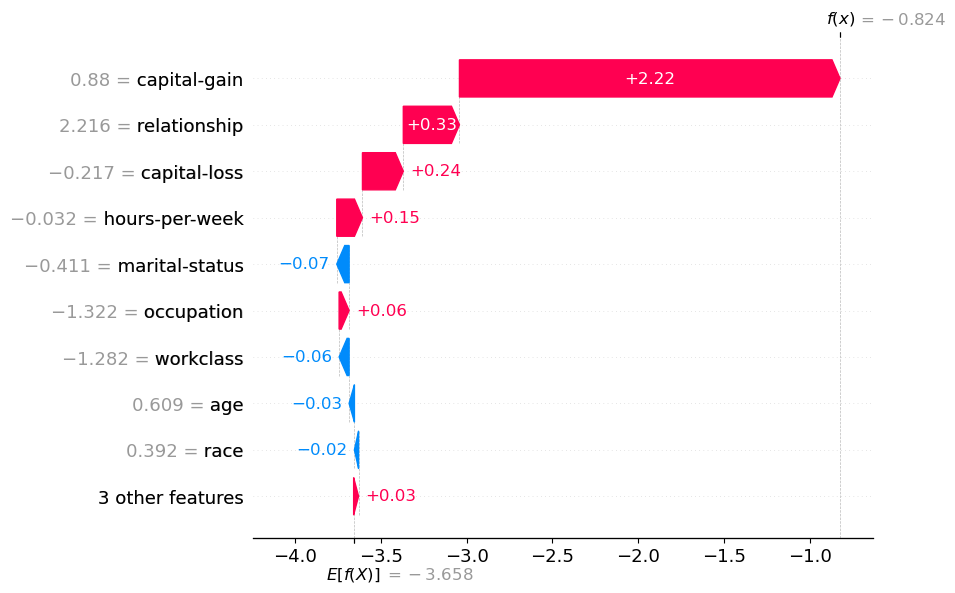

In [22]:
import shap
import matplotlib.pyplot as plt

# Function to create a SHAP waterfall plot for a given instance
def create_waterfall_plot(shap_values, instance_index, feature_names):
    """
    Create a SHAP waterfall plot for a specific instance.

    :param shap_values: SHAP values for the entire dataset
    :param instance_index: Index of the instance to plot
    :param feature_names: List of feature names
    """
    # Select the SHAP values for the instance
    instance_shap_values = shap_values[instance_index]

    # Ensure the SHAP values object contains the required information for the plot
    explanation = shap.Explanation(
        values=instance_shap_values.values,
        base_values=instance_shap_values.base_values,
        data=instance_shap_values.data,
        feature_names=feature_names
    )
    
    # Create the waterfall plot
    shap.plots.waterfall(explanation)

print("Waterfall plot for men")
create_waterfall_plot(tn_df_0_shap_values, instance_index=0, feature_names=features)

False positives for men:


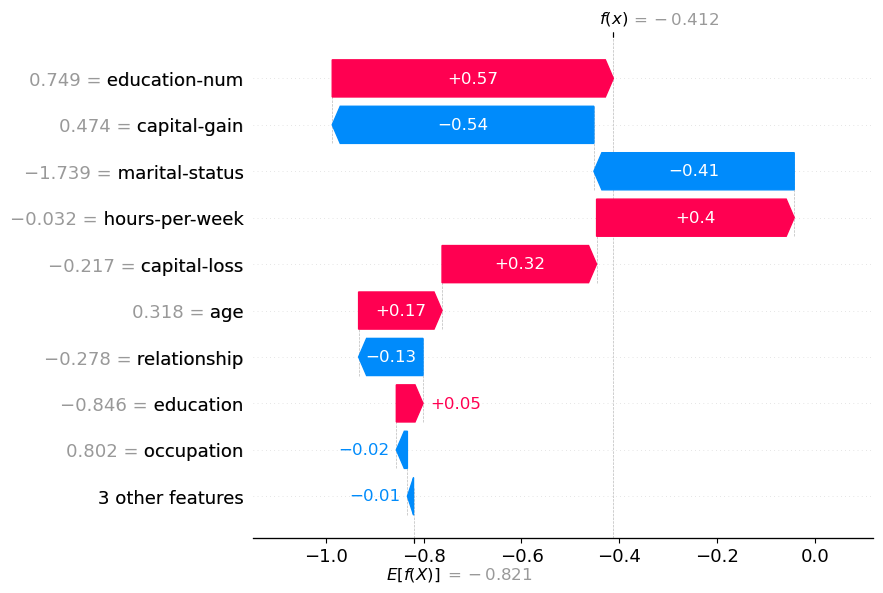

True positives for women:


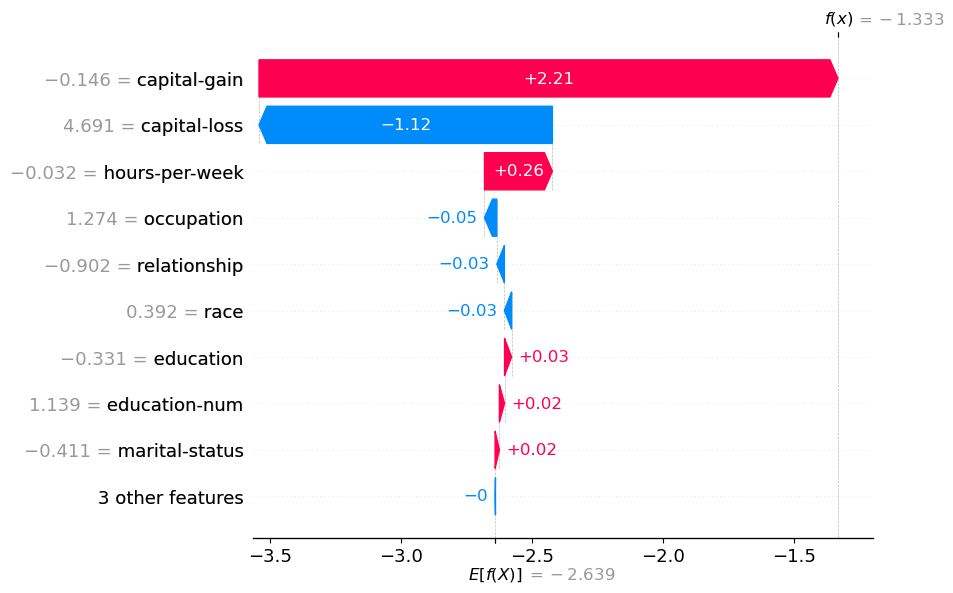

False positives for women:


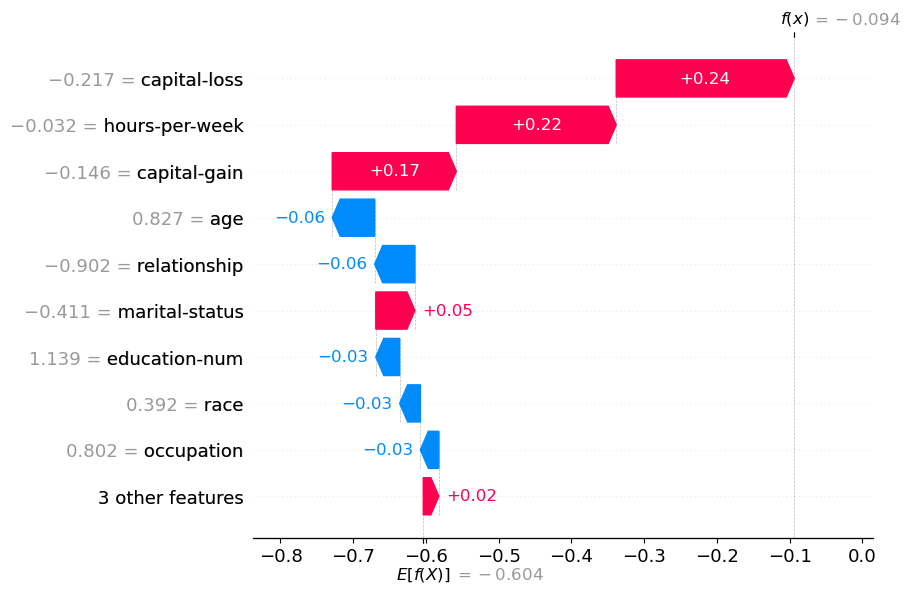

In [25]:
print("False positives for men:")

create_waterfall_plot(fn_df_0_shap_values, instance_index=0, feature_names=features)
    
print("True positives for women:")

create_waterfall_plot(tn_df_1_shap_values, instance_index=0, feature_names=features)

print("False positives for women:")

create_waterfall_plot(fn_df_1_shap_values, instance_index=0, feature_names=features)

## SHAPley values with Random Forest

In [29]:
data, features, target, numeric_columns, categorical_columns = load_adult()

target = 'target'
attribute = 'sex'
classifier_type = 'random_forest'

# Calculate metrics and get the test DataFrame with predictions
results, test_df, trained_model = calculate_metrics_and_split_data(data, features, target, classifier_type, attribute=attribute)

# Generate DataFrames for true positives and false positives
tn_df_0, fn_df_0, tn_df_1, fn_df_1 = generate_tn_fn_dataframes(test_df, target, attribute)

print("Results:")
for metric, value in results.items():
    print(f"{metric}: {value}")

print("True Positives Group 0 (first 5 rows):")
print(tn_df_0.head())

print("False Positives Group 0 (first 5 rows):")
print(fn_df_0.head())

print("True Positives Group 1 (first 5 rows):")
print(tn_df_1.head())

print("False Positives Group 1 (first 5 rows):")
print(fn_df_1.head())

Training data shape: X_train: (39073, 12), y_train: (39073,)
Testing data shape: X_test: (9769, 12), y_test: (9769,)
Confusion Matrix:
[[1447  908]
 [ 585 6829]]
Accuracy: 0.847169618179957
Test data with all columns:
            age  workclass  education  education-num  marital-status  \
7762   0.013699       0.50   0.733333       0.533333        0.666667   
23881  0.000000       0.50   0.133333       0.466667        0.666667   
30507  0.109589       0.25   0.733333       0.533333        0.666667   
28911  0.041096       0.50   1.000000       0.600000        0.666667   
19484  0.410959       0.50   0.733333       0.533333        0.666667   

       occupation  relationship  race  sex  capital-gain  capital-loss  \
7762     0.571429           0.2   1.0  1.0           0.0           0.0   
23881    0.857143           0.6   1.0  0.0           0.0           0.0   
30507    0.428571           0.4   0.5  1.0           0.0           0.0   
28911    0.857143           0.6   1.0  0.0           

In [40]:
import shap
import numpy as np
import pandas as pd

# Function to calculate and aggregate SHAP values
def compute_shap_values_and_aggregate(df, features, group_name):
    """
    Compute SHAP values for the given group and aggregate them across instances.
    
    :param df: DataFrame containing the data (e.g., tp_df_0, fp_df_0)
    :param features: List of feature columns
    :param group_name: A label for the group (e.g., 'tp_df_0')
    :return: Aggregated SHAP values and original SHAP values
    """
    # Compute SHAP values for the given group
    shap_values = explainer(df[features])
    
    # Check if the SHAP values are for a multi-class model
    if len(shap_values.values.shape) > 2:
        # Assuming binary classification, select SHAP values for the positive class (class 1)
        shap_values_class = shap_values.values[..., 1]  # Use values for class 1
    else:
        shap_values_class = shap_values.values
    
    # Aggregate SHAP values by taking the mean across all instances in the group
    mean_shap_values = np.mean(shap_values_class, axis=0)
    
    # Convert to DataFrame for easy comparison
    shap_df = pd.DataFrame({
        'feature': features,
        'mean_shap_value': mean_shap_values
    })
    
    print(f"\nAggregated SHAP values for {group_name}:")
    print(shap_df.sort_values(by='mean_shap_value', ascending=False))
    
    return shap_values, shap_df

# Example: Compute SHAP values for a specific group
tn_df_0_shap_values, tn_df_0_shap_agg = compute_shap_values_and_aggregate(tn_df_0, features, 'tn_df_0')
fn_df_0_shap_values, fn_df_0_shap_agg = compute_shap_values_and_aggregate(fn_df_0, features, 'fn_df_0')
tn_df_1_shap_values, tn_df_1_shap_agg = compute_shap_values_and_aggregate(tn_df_1, features, 'tn_df_1')
fn_df_1_shap_values, fn_df_1_shap_agg = compute_shap_values_and_aggregate(fn_df_1, features, 'fn_df_1')

  0%|          | 0/206 [00:00<?, ?it/s]

KeyboardInterrupt: 